In [1]:
#code by Cian Kingston
import os,re,sys,pickle,datetime,time,random,itertools
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import openpyxl
from openpyxl import load_workbook
import pandas as pd
import math
import seaborn as sns 
import umap
import umap.plot
from bokeh.plotting import figure, show, save, output_notebook, output_file
from bokeh.resources import INLINE 
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import RdBu3,RdBu9
from PIL import Image
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.decomposition import PCA
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
randomstate = 42
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDConfig
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import PropertyMol
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing,DrawingOptions
DrawingOptions.bondLineWidth=1.8
DrawingOptions.includeAtomNumbers=False
size = (150, 150)
from rdkit.Chem.Draw.MolDrawing import Font
from rdkit.Chem import rdmolfiles
from rdkit.Chem import rdFMCS

**Load data**

In [2]:
ci = pd.read_excel('gen_descriptors.xlsx','Sheet1',index_col=0,header=1,engine='openpyxl')
compinp = ci[ci.columns[1:-3]].loc[ci.index[:]]
compinp.index = compinp.index.astype(int)
compinp.dropna(axis=0,inplace=True)

inp2 = pd.read_excel("gen_identifiers.xlsx",index_col=1,header=2,engine='openpyxl')
inp2.index = inp2.index.astype(int)

rxndata = pd.read_excel("gen_rxn_data.xlsx","Phosphines",header=2,index_col=2,nrows=1776,engine='openpyxl')

**Remove colinear descriptors**

In [3]:
threshold = 0.95
print('Shape of descriptors file before curation: ',compinp.shape)
df_corr = compinp.corr()
df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
compinp = compinp[un_corr_idx]
print('Shape of descriptors file after curation: ',compinp.shape)

Shape of descriptors file before curation:  (1544, 190)
Shape of descriptors file after curation:  (1544, 139)


**Create subsets from the identifiers file and scale the data**

In [4]:
X_all = np.array(compinp)
X_gen_considered = np.array(compinp.loc[inp2["gen_considered"]==1])
X_gen_chosen = np.array(compinp.loc[inp2["gen_chosen"]==1])
X_gen_THF_HTE = np.array(compinp.loc[inp2["gen_THF_HTE"]==1])
X_gen_tAmOH_HTE = np.array(compinp.loc[inp2["gen_tAmOH_HTE"]==1])

X_all_ids = np.array(compinp.index)
X_gen_considered_ids = np.array(compinp.loc[inp2["gen_considered"]==1].index)
X_gen_chosen_ids = np.array(compinp.loc[inp2["gen_chosen"]==1].index)
X_gen_THF_HTE_ids = np.array(compinp.loc[inp2["gen_THF_HTE"]==1].index)
X_gen_tAmOH_HTE_ids = np.array(compinp.loc[inp2["gen_tAmOH_HTE"]==1].index)

X_all_names = np.array(inp2["ligand"].loc[X_all_ids])
X_gen_considered_names = np.array(inp2['ligand'].loc[X_gen_considered_ids])
X_gen_chosen_names = np.array(inp2['ligand'].loc[X_gen_chosen_ids])
X_gen_THF_HTE_names = np.array(inp2['ligand'].loc[X_gen_THF_HTE_ids])
X_gen_tAmOH_HTE_names = np.array(inp2['ligand'].loc[X_gen_tAmOH_HTE_ids])

scaler = StandardScaler()
scaler.fit(X_all)
X_all_sc    = scaler.transform(X_all)
X_gen_considered_sc = scaler.transform(X_gen_considered)
X_gen_chosen_sc = scaler.transform(X_gen_chosen)
X_gen_THF_HTE_sc = scaler.transform(X_gen_THF_HTE)
X_gen_tAmOH_HTE_sc = scaler.transform(X_gen_tAmOH_HTE)

**Plotting multiple sets**

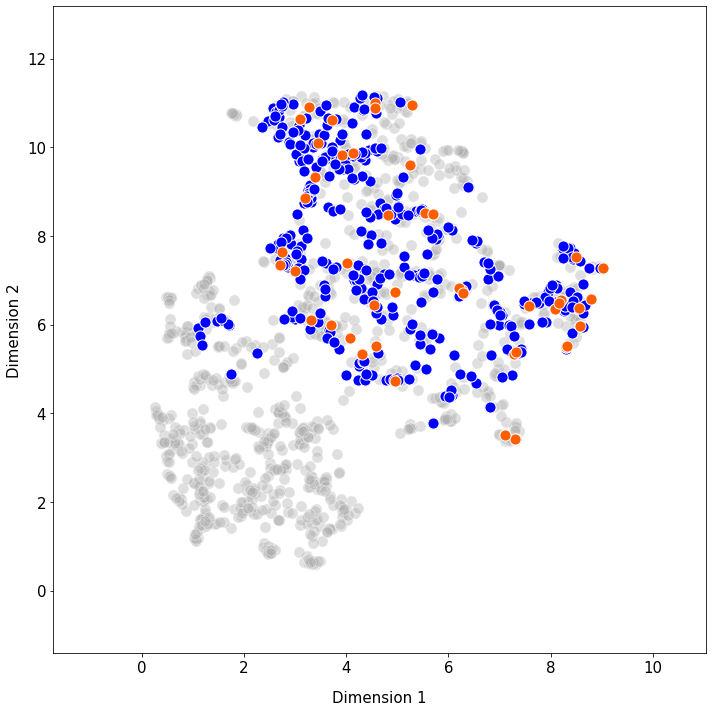

In [5]:
X_main_sc = X_all_sc
X_main_ids = X_all_ids
X_subset1_ids = X_gen_considered_ids
X_subset2_ids = X_gen_chosen_ids

reducer = umap.UMAP(random_state=42)
reducer.fit(X_main_sc)
X_all_red = reducer.transform(X_main_sc)

f_ind_1 = 0
f_ind_2 = 1
x_min, x_max = X_all_red[:, f_ind_1].min() - 2, X_all_red[:, f_ind_1].max() + 2
y_min, y_max = X_all_red[:, f_ind_2].min() - 2, X_all_red[:, f_ind_2].max() + 2
plt.figure(figsize=(10,10))
extent = [x_min,x_max,y_min,y_max]
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)
plt.xlabel(f"Dimension {f_ind_1+1}",fontsize=15,labelpad=15)
plt.ylabel(f"Dimension {f_ind_2+1}",fontsize=15,labelpad=5)
plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=10)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
    
main_set = []
subset1 = []
subset2 = []
for i in range(0,len(X_main_ids)):
    if X_main_ids[i] in X_subset1_ids:
        x = X_all_red[i].tolist()
        subset1.append(x)
    if X_main_ids[i] in X_subset2_ids:
        x = X_all_red[i].tolist()
        subset2.append(x)
    else:
        x = X_all_red[i].tolist()
        main_set.append(x)
main_set = np.asarray(main_set)
subset1 = np.asarray(subset1)
subset2 = np.asarray(subset2)

plt.scatter(main_set[:,f_ind_1], main_set[:,f_ind_2],c='#B1B1B1',alpha=0.4,marker=".",s=500,edgecolor='white') 
plt.scatter(subset1[:,f_ind_1], subset1[:,f_ind_2],c='#0000FF',alpha=1,marker='.',s=500,edgecolor='white')
plt.scatter(subset2[:,f_ind_1], subset2[:,f_ind_2],c='#FF5D00',alpha=1,marker='.',s=500,edgecolor='white')

plt.tight_layout()
plt.show()  
#plt.savefig("umap.png",dpi=300)

**Plot subset with size of points by yield and color by selectivity**

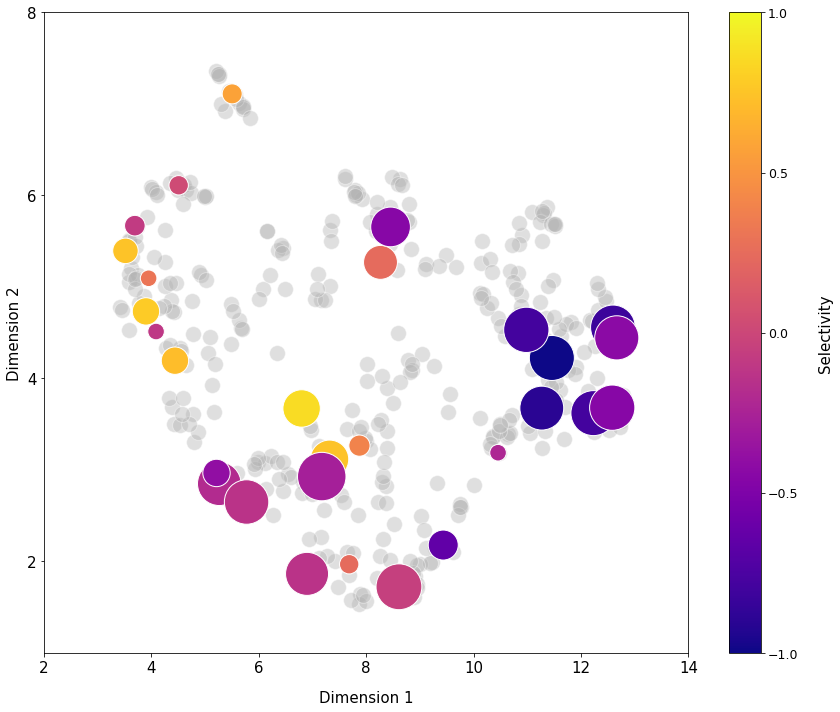

In [7]:
X_main_sc = X_gen_considered_sc
X_main_ids = X_gen_considered_ids
X_subset1_ids = X_gen_THF_HTE_ids

reducer = umap.UMAP(random_state=42)
reducer.fit(X_main_sc)
X_all_red = reducer.transform(X_main_sc)

f_ind_1 = 0
f_ind_2 = 1
x_min, x_max = X_all_red[:, f_ind_1].min() - 2, X_all_red[:, f_ind_1].max() + 2
y_min, y_max = X_all_red[:, f_ind_2].min() - 2, X_all_red[:, f_ind_2].max() + 2
plt.figure(figsize=(12,10))
extent = [x_min,x_max,y_min,y_max]
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)
plt.xlabel(f"Dimension {f_ind_1+1}",fontsize=15,labelpad=15)
plt.ylabel(f"Dimension {f_ind_2+1}",fontsize=15,labelpad=5)
plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=10)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
    
main_set = []
subset1 = []
for i in range(0,len(X_main_ids)):
    if X_main_ids[i] in X_subset1_ids:
        x = X_all_red[i].tolist()
        subset1.append(x)
    else:
        x = X_all_red[i].tolist()
        main_set.append(x)
main_set = np.asarray(main_set)
subset1 = np.asarray(subset1)

plt.scatter(main_set[:,f_ind_1], main_set[:,f_ind_2],c='#B1B1B1',alpha=0.4,marker=".",s=1000,edgecolor='white') 
a = list(rxndata["3aa THF/H2O selectivity (ddG in kcal/mol)"])
b = [x for x in a if str(x) != 'nan']
c = list(rxndata["3aa THF/H2O high yields (%)"])
d = [x for x in c if str(x) != 'nan']
e = [x*100 for x in d]
plt.scatter(subset1[:,f_ind_1], subset1[:,f_ind_2],c=b,cmap='plasma',alpha=1,marker='.',s=e,edgecolor='white') 
cbar = plt.colorbar()
cbar.ax.locator_params(nbins=5)
plt.clim(vmin=-1, vmax=1)
cbar.set_label('Selectivity',rotation=90,size=15,labelpad=20)
cbar.ax.tick_params(labelsize=12.5)
plt.xlim(2, 14)
plt.locator_params(axis='x', nbins=6)
plt.ylim(1, 8)
plt.locator_params(axis='y', nbins=6)

plt.tight_layout()
plt.show()  
#plt.savefig("umapthf.png",dpi=300)